# k-means

算法流程：

![pic1](./1.png)

其实理解起来比较直观，就是一个迭代。

接口（[官方文档](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)）：

```py
class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')
```

Kmeans 性能评估指标，轮廓系数：

$$
sc_i = \frac{\bar{b_i} - \bar{a_i}}{\mathrm{max}(b_i) - \mathrm{min}(a_i)}
$$

注：$i$ 代表一个样本，$\bar{b_i}$ 为 $i$ 到最近族群的所有样本的平均距离，$\bar{a_i}$ 为 $i$ 到本身簇的距离平均值。分母的作用是归一化。

![pic2](./2.png)

轮廓系数 $\in [-1, 1]$ ，超过 0.1 说明聚类效果很好（经验）。


In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

读取四张表的数据。

In [ ]:
# 读取了订单和产品的关联，csv比较大
prior = pd.read_csv("./data/instacart/order_products__prior.csv")

In [ ]:
# 产品id和产品名称的对应
products = pd.read_csv("./data/instacart/products.csv")

In [ ]:
# 订单id和用户id的对应，csv比较大
orders = pd.read_csv("./data/instacart/orders.csv")

In [ ]:
# 超市的过道，过道放的产品的品类
aisles = pd.read_csv("./data/instacart/aisles.csv")

In [6]:
# 合并四张表到一张表  （用户-物品类别）
_mg = pd.merge(prior, products, on=['product_id', 'product_id'])
_mg = pd.merge(_mg, orders, on=['order_id', 'order_id'])
mt = pd.merge(_mg, aisles, on=['aisle_id', 'aisle_id'])

In [8]:
mt.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs
1,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,eggs
2,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,eggs
3,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,eggs
4,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,eggs
5,537,33120,2,1,Organic Egg Whites,86,16,180135,prior,15,2,8,3.0,eggs
6,582,33120,7,1,Organic Egg Whites,86,16,193223,prior,6,2,19,10.0,eggs
7,608,33120,5,1,Organic Egg Whites,86,16,91030,prior,11,3,21,12.0,eggs
8,623,33120,1,1,Organic Egg Whites,86,16,37804,prior,63,3,12,3.0,eggs
9,689,33120,4,1,Organic Egg Whites,86,16,108932,prior,16,1,13,3.0,eggs


In [9]:
mt.shape

(32434489, 14)

看一下用户喜欢买哪些过道的货物。

In [10]:
# 交叉表（特殊的分组工具），如果在这一步内存不够了，重启一下jupyter
cross = pd.crosstab(mt['user_id'], mt['aisle'])

In [11]:
cross.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,5
8,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,6,0,2,0,0,0,...,0,0,0,0,0,0,0,2,0,19


In [12]:
cross.shape

(206209, 134)

In [ ]:
pca = PCA(n_components=0.9)
pca

PCA(n_components=0.9)

In [ ]:
data = pca.fit_transform(cross)
data
data.shape

(206209, 27)

In [15]:
# 把样本数量减少
x = data[:500]
x.shape

(500, 27)

In [14]:
x

array([[-24.21565874,   2.4294272 ,  -2.46636975, ...,   0.68680034,
          1.69439402,  -2.34323022],
       [  6.46320806,  36.75111647,   8.38255336, ...,   4.12121252,
          2.4468974 ,  -4.28348478],
       [ -7.99030162,   2.40438257, -11.03006405, ...,   1.77534453,
         -0.44419403,   0.78666557],
       ...,
       [-11.92661183,  -6.28156437,   6.49043833, ...,  -0.93499096,
         -0.1409791 ,   0.04370174],
       [-18.05675245,  -0.42589035,  -3.92660866, ...,  -1.02048351,
         -0.95283767,   0.90135767],
       [-24.62244434,  -0.5635177 ,  -0.90551124, ...,   0.86904501,
         -2.15569229,  -0.40915483]])

In [16]:
x.max()

407.18563418250557

In [17]:
x.min()

-242.3484794930586

假设用户一共分为四个类别：

In [ ]:
km = KMeans(n_clusters=4)

In [19]:
km.fit(x)  #开始训练

KMeans(n_clusters=4)

In [ ]:
# 开始预测
predict = km.predict(x)

In [21]:
predict

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1,
       1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1,
       1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1,
       1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1,
       3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1,
       1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [22]:
len(predict)

500

In [23]:
# 显示聚类的结果
plt.figure(figsize=(20, 20))

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

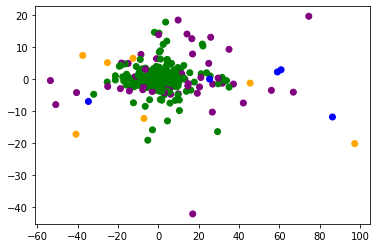

In [ ]:
# 建立四个颜色的列表
colored = ['orange', 'green', 'blue', 'purple']
colr = [colored[i] for i in predict]
# 取任意两个特征来看聚类的图
plt.scatter(x[:, 2], x[:, 20], color=colr)

In [62]:
x

array([[-24.21565874,   2.4294272 ,  -2.46636975, ...,   0.68680034,
          1.69439402,  -2.34323022],
       [  6.46320806,  36.75111647,   8.38255336, ...,   4.12121252,
          2.4468974 ,  -4.28348478],
       [ -7.99030162,   2.40438257, -11.03006405, ...,   1.77534453,
         -0.44419403,   0.78666557],
       ...,
       [-11.92661183,  -6.28156437,   6.49043833, ...,  -0.93499096,
         -0.1409791 ,   0.04370174],
       [-18.05675245,  -0.42589035,  -3.92660866, ...,  -1.02048351,
         -0.95283767,   0.90135767],
       [-24.62244434,  -0.5635177 ,  -0.90551124, ...,   0.86904501,
         -2.15569229,  -0.40915483]])

Text(0, 0.5, '20')

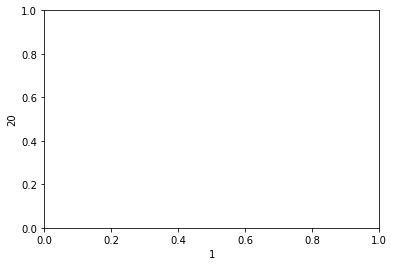

In [63]:
plt.xlabel("1")
plt.ylabel("20")

In [64]:
plt.show()

In [25]:
# 评判聚类效果，轮廓系数，聚类效果很难超过0.7，可以通过这个得分去调整上面KMeans的n_clusters
silhouette_score(x, predict)

0.6102387230295738

In [ ]:
# 改为2时的结果
km = KMeans(n_clusters=2)
km.fit(x)  #开始训练
predict = km.predict(x)
silhouette_score(x, predict)

0.6779999767609063

In [27]:
#改为3时的结果
km = KMeans(n_clusters=3)
km.fit(x)  #开始训练
predict = km.predict(x)
silhouette_score(x, predict)

0.6471264722807814

# 找异常值的方法

https://www.zhihu.com/question/38066650/answer/549125707  （已在 github 备份）

DBSCAN 解释：
https://zh.wikipedia.org/wiki/DBSCAN